# Research Track 2 - Assignment 2
## Jupyter on Node (a) of ros_robot_sim_pkg
### Ami Sofia Quijano Shimizu

### This Notebook contains:
* An interface to assign (or cancel) goals to the robot
* Visualization of current robot position, sent targets, cancelled targets and reached targets
* A plot with the robot’s position and targets’ positions in the environment
* A plot for the number of reached/not-reached targets

### Useful imports

In [1]:
%matplotlib notebook
import rospy
import actionlib
import actionlib.msg
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
from nav_msgs.msg import Odometry
from ros_robot_sim_pkg.msg import PlanningAction, PlanningGoal, PlanningFeedback 

### Creation of Widgets

In [2]:
# Widget for X coordinate input 
x_input = widgets.FloatText(description = 'Target X (flt):', 
                            layout = widgets.Layout(height = '30px', width = '150px'))

# Widget for Y coordinate input 
y_input = widgets.FloatText(description = 'Target Y (flt):',
                           layout = widgets.Layout(height = '30px', width = '150px'))

# Widget for entering the X Y coordinates
send_button = widgets.Button(description = 'Send Target')

# Widget for cancelling the goal
cancel_button = widgets.Button(description = 'Cancel Target')

# Widget for displaying user Log
log_info = widgets.Text(description = 'Log info', disabled = True,
                       layout = widgets.Layout(height = '30px', width = '270px'))

# Widget for displaying Current position and Status of robot
robot_pos = widgets.Textarea(description = 'Robot Pos:', disabled = True, 
                              layout = widgets.Layout(height = '50px', width = '350px')) 

# Widget for displaying Targets sent
sent_info = widgets.Textarea(description = 'Sent:', disabled = True, 
                              layout = widgets.Layout(height = '100px', width = '170px')) 

# Widget for displaying Targets cancelled
cancelled_info = widgets.Textarea(description = 'Cancelled:', disabled = True, 
                              layout = widgets.Layout(height = '100px', width = '170px')) 

# Widget for displaying Targets reached
reached_info = widgets.Textarea(description = 'Reached:', disabled = True, 
                              layout = widgets.Layout(height = '100px', width = '170px')) 

# Widget for displaying Plot of reached vs cancelled targets
target_graph = widgets.Output()

# Widget for displaying Plot of trajectory
traj_graph = widgets.Output()

### Function for sending the goal coordinates

In [3]:
def send_goal(_):
    # Allocate the X and Y goal coordinates in PlanningGoal() action message from user input
    goal.target_pose.pose.position.x = x_input.value
    goal.target_pose.pose.position.y = y_input.value

    # Send the goal to the action-server
    action_client.send_goal(goal)
    
    # Fill widgets with Log info and Sent target coordinates
    log_info.value = 'Target coordinates sent!'
    sent_info.value += f'({x_input.value}, {y_input.value})\n'

### Function for cancelling current goal

In [4]:
def cancel_target(_):
    global target_active, targets_cancelled_count
    
    # If moving towards target
    if target_active:
        # Cancel current goal
        action_client.cancel_goal()
        
        # Add 1 to the total # of targets cancelled
        targets_cancelled_count += 1
        
        # Fill widgets with Log info and Cancelled target coordinates
        log_info.value = 'Target cancelled!'
        cancelled_info.value += f'({x_input.value}, {y_input.value})\n'
        
        plot_targets()
    
    # If not moving towards target (was cancelled or reached), fill widget with Log info
    else:
        log_info.value = 'No active target to cancel'

### Callback function of /reaching_goal/feedback

In [5]:
def feedback_callback(feedback_msg):
    global targets_reached_count, target_active
    
    # Allocate X and Y positions and Status obtained from /reaching_goal/feedback
    pos_x = feedback_msg.feedback.actual_pose.position.x
    pos_y = feedback_msg.feedback.actual_pose.position.y
    status = feedback_msg.feedback.stat
    
    # Fill widget with Robot's X and Y positions
    robot_pos.value = f"CURRENT X: {pos_x} \nCURRENT Y: {pos_y}"  
    
    # If target has been reached,
    if status == 'Target reached!':
        # Set flag as False
        target_active = False
        
        # Add 1 to the total # of targets reached
        targets_reached_count += 1
        
        # Fill widgets with Log info and Reached target coordinates
        log_info.value = status
        reached_info.value += f'({x_input.value}, {y_input.value})\n'
        
        plot_targets()
        
    # If target has been cancelled, set flag as False
    elif status == 'Target cancelled!':
        target_active = False
    
    # If target is still being reached by robot, set flag as True
    else:
        target_active = True

### Callback function of /odom

In [6]:
def odom_callback(odom_msg):
    global traj_x, traj_y
   
    # Append robot trajectory coordinates
    traj_x.append(odom_msg.pose.pose.position.x)
    traj_y.append(odom_msg.pose.pose.position.y)

### Function for plotting Reached vs Cancelled targets

In [7]:
def plot_targets():
    global targets_reached_count, targets_cancelled_count
    
    # Clear the previous output
    target_graph.clear_output(wait = True)
    
    # Set bar graph and size
    fig, ax = plt.subplots(figsize = (2.5,4))
    
    # Set parameters
    ax.bar(['Reached', 'Cancelled'], [targets_reached_count, targets_cancelled_count], 
           color = ['green', 'red'])
    ax.set_xlabel('Target Status', fontsize = 9)
    ax.set_ylabel('Count', fontsize = 9)
    ax.set_title('Reached vs Cancelled Targets', fontsize = 10)
    ax.tick_params(axis='both', which='major', labelsize = 9)
    ax.grid(True)
    
    # Set interval size limits
    max_count = max(targets_reached_count, targets_cancelled_count)
    ax.set_ylim(0, max_count * 1.1)
    tick_interval = max(1, max_count //5)
    ax.yaxis.set_major_locator(plt.MultipleLocator(tick_interval))
    
    # Display plot
    with target_graph:
        plt.show()

### Function for plotting Robot Position

In [8]:
def update_plot(frame):
    global traj_x, traj_y
    
    print("Updating plot with frame:", frame)
    
    # Set plot
    line.set_data(traj_x[:frame], traj_y[:frame])
    
    # Clear previous output
    #traj_graph.clear_output(wait = True)
    
    #with traj_graph:
    #    plt.show()
   
    return line,

### Main

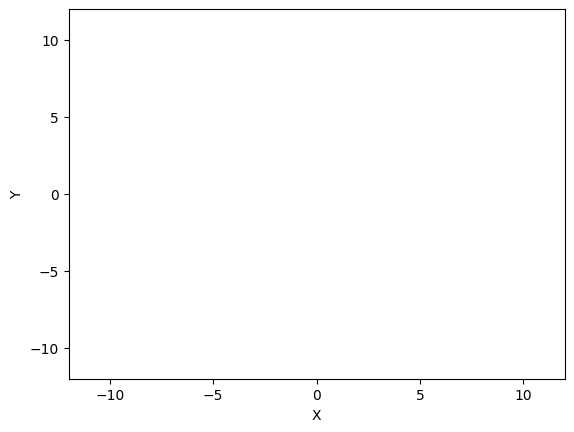

In [9]:
# Initialize node
rospy.init_node('node_jupyter')

ani = None

# Create an action-client for /reaching_goal server with action message Planning
action_client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)

# Create a subscriber for the action-server feedback for having current position and status
subscriber1 = rospy.Subscriber('/reaching_goal/feedback', PlanningFeedback, feedback_callback) 

# Create a subscriber for the action-server feedback for having current position and status
subscriber2 = rospy.Subscriber('/odom', Odometry, odom_callback) 

# Create the goal object of Planning to send to the action-server
goal = PlanningGoal()

# Initialize counters for reached and cancelled targets
targets_reached_count = 0
targets_cancelled_count = 0

# Initialize flag: indicates if robot is still reaching the target or not anymore
target_active = False

traj_x = []
traj_y = []

# Call send_goal() when send_button is pressed
#+send_button.on_click(send_goal)

# Call cancel_goal() when cancel_button is pressed
#cancel_button.on_click(cancel_target)

# Display widgets
#display(widgets.VBox([widgets.HBox([x_input, y_input, send_button, cancel_button]), 
#                      widgets.HBox([log_info, robot_pos]),
#                      widgets.HBox([sent_info, cancelled_info, reached_info]),
#                      widgets.HBox([target_graph, traj_graph])]))


fig, ax = plt.subplots()
line, = ax.plot([], [], 'ro')
ax.set_xlim(-12, 12)
ax.set_ylim(-12, 12)
ax.set_xlabel('X')
ax.set_ylabel('Y')

ani = FuncAnimation(fig, update_plot, frames=len(traj_x), interval=100)
plt.show(block=True)

# Stop node when Jupyter shuts down
rospy.on_shutdown(rospy.signal_shutdown)